In [1]:
import pandas as pd
import requests
import re
import time
from bs4 import BeautifulSoup

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def fetch(url):
    """
    Use BeautifulSoup to get the text of a web page.
    """
    r = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("", r.text), "html.parser")
    return soup

Steps:  
- Go to draft year page at BBR and identify CBB players (Ex: https://www.basketball-reference.com/draft/NBA_2021.html)
- Go to the bio pages at BBR of all the CBB draftees and find their bio pages at Sports-Reference (Ex: https://www.basketball-reference.com/players/c/cunnica01.html)
- Obtain info of all the CBB draftees at their bio pages at Sports-Reference (Ex: https://www.sports-reference.com/cbb/players/cade-cunningham-1.html)

In [5]:
def get_draftee_spr_page(player_bbr_url):
    """
    Input: a draftee's url at BBR
    Output: a draftee's url at Sports-Reference
    """
    spr_url = 'https://www.sports-reference.com'
    bbr_bio_soup = fetch(player_bbr_url)
    div_soup = bbr_bio_soup.find_all('div', {'id': 'inner_nav'})[0]
    for link in div_soup.find_all('a'):
        if spr_url in link['href']:
            return link['href']

In [13]:
def get_draftee_info_last_cbb_season(year, player_spr_url):
    """
    Input: draft year; a draftee's url at Sports-Reference
    Output: a draftee's conference, minutes played, games played, 
            bpm in his final college sesason (also in the year of draft)
    """
    spr_bio_soup = fetch(player_spr_url)
    advanced_table = spr_bio_soup.find_all('table', {'id': 'players_advanced'})[0]
    
    row = advanced_table.find_all('tr', {'id': f'players_advanced.{year}'})
    if row:
        info_list = ['conf_abbr', 'g', 'mp', 'bpm']
        return [row[0].find_all('td', {'data-stat': stat})[0].text for stat in info_list]
    else:
        # In case of De'Anthony Melton (class 2018), he didn't play 2017-18 CBB season due to 
        # college recruiting scandal. 
        return ['' for i in range(4)] 

In [7]:
def get_draftees_cbb_bpm(year, test=False):
    """
    Input: draft year
    Output: a dataframe of draftees' info
    """
    
    print(f'NBA Draft {year} Scraping...')
    
    bbr_url = 'https://www.basketball-reference.com'
    draft_yr_url = f'{bbr_url}/draft/NBA_{year}.html'
    draft_yr_soup = fetch(draft_yr_url)
    draft_table = draft_yr_soup.find_all('table', {'id': 'stats'})[0]
    
    draftee_list = []
    for row in draft_table.find_all('tr'):
        if row.find_all('td', {'data-stat': 'pick_overall'}):
            pick = row.find_all('th')[0].text
            player = row.find_all('td', {'data-stat': 'player'})[0].text
            if test == True:
                print(pick, player)
            college_name = row.find_all('td', {'data-stat': 'college_name'})[0].text
            player_bbr_url = f"{bbr_url}{row.find_all('td', {'data-stat': 'player'})[0].a['href']}"
            if college_name != '':
                player_spr_url = get_draftee_spr_page(player_bbr_url)
                if player_spr_url:
                    draftee_info = get_draftee_info_last_cbb_season(year, player_spr_url)
                else:
                    # In case of Filip Petrušev (class 2021), he didn't play 2020-21 CBB season 
                    # and chose to return Serbia due to Covid-19.
                    draftee_info = ['' for i in range(4)]
            else:
                draftee_info = ['' for i in range(4)]
                
            draftee_list.append([pick, player, college_name, player_bbr_url] + draftee_info)
    
    cols = ['pick', 'player', 'college_name', 'bbr_url', 
            'conference_name', 'games_played', 'minutes_played', 'bpm']
    draftee_df = pd.DataFrame(draftee_list, columns=cols)
    
    print(f'NBA Draft {year} Completed.')
    print()
    
    return draftee_df

## Scrape

In [17]:
# Ex
year = 2021
get_draftees_cbb_bpm(year, test=True).to_csv(f'nba_draft_year_bpm/{year}', index=False)

NBA Draft 2021 Scraping...
1 Cade Cunningham
2 Jalen Green
3 Evan Mobley
4 Scottie Barnes
5 Jalen Suggs
6 Josh Giddey
7 Jonathan Kuminga
8 Franz Wagner
9 Davion Mitchell
10 Ziaire Williams
11 James Bouknight
12 Joshua Primo
13 Chris Duarte
14 Moses Moody
15 Corey Kispert
16 Alperen Şengün
17 Trey Murphy III
18 Tre Mann
19 Kai Jones
20 Jalen Johnson
21 Keon Johnson
22 Isaiah Jackson
23 Usman Garuba
24 Josh Christopher
25 Quentin Grimes
26 Bones Hyland
27 Cameron Thomas
28 Jaden Springer
29 Day'Ron Sharpe
30 Santi Aldama
31 Isaiah Todd
32 Jeremiah Robinson-Earl
33 Jason Preston
34 Rokas Jokubaitis
35 Herb Jones
36 Miles McBride
37 JT Thor
38 Ayo Dosunmu
39 Neemias Queta
40 Jared Butler
41 Joe Wieskamp
42 Isaiah Livers
43 Greg Brown III
44 Kessler Edwards
45 Juhann Begarin
46 Dalano Banton
47 David Johnson
48 Sharife Cooper
49 Marcus Zegarowski
50 Filip Petrušev
51 Brandon Boston Jr.
52 Luka Garza
53 Charles Bassey
54 Sandro Mamukelashvili
55 Aaron Wiggins
56 Scottie Lewis
57 Balša Kopriv

In [16]:
for year in range(2011, 2021):
    get_draftees_cbb_bpm(year).to_csv(f'nba_draft_year_bpm/{year}', index=False)
    time.sleep(10)

NBA Draft 2011 Scraping...
NBA Draft 2011 Completed.

NBA Draft 2012 Scraping...
NBA Draft 2012 Completed.

NBA Draft 2013 Scraping...
NBA Draft 2013 Completed.

NBA Draft 2014 Scraping...
NBA Draft 2014 Completed.

NBA Draft 2015 Scraping...
NBA Draft 2015 Completed.

NBA Draft 2016 Scraping...
NBA Draft 2016 Completed.

NBA Draft 2017 Scraping...
NBA Draft 2017 Completed.

NBA Draft 2018 Scraping...
NBA Draft 2018 Completed.

NBA Draft 2019 Scraping...
NBA Draft 2019 Completed.

NBA Draft 2020 Scraping...
NBA Draft 2020 Completed.



## EDA

In [25]:
draftee_dict = {}
for year in range(2011, 2022):
    draftee_df = pd.read_csv(f'nba_draft_year_bpm/{year}') 
    draftee_df['year'] = year
    print(f'NBA Draft {year}')
    max_bpm_player_row = draftee_df[draftee_df['bpm'] == draftee_df['bpm'].max()]
    min_bpm_player_row = draftee_df[draftee_df['bpm'] == draftee_df['bpm'].min()]
    print(f"Player with Highest BPM: {max_bpm_player_row['player'].values[0]}({draftee_df['bpm'].max()})")
    print(f"Player with Lowest BPM: {min_bpm_player_row['player'].values[0]}({draftee_df['bpm'].min()})")
    print()
    draftee_dict[year] = draftee_df

NBA Draft 2011
Player with Highest BPM: Kyrie Irving(14.8)
Player with Lowest BPM: Josh Selby(2.4)

NBA Draft 2012
Player with Highest BPM: Anthony Davis(17.2)
Player with Lowest BPM: Kevin Murphy(0.6)

NBA Draft 2013
Player with Highest BPM: Victor Oladipo(15.1)
Player with Lowest BPM: Archie Goodwin(2.1)

NBA Draft 2014
Player with Highest BPM: K.J. McDaniels(12.9)
Player with Lowest BPM: Johnny O'Bryant(1.3)

NBA Draft 2015
Player with Highest BPM: Frank Kaminsky(16.2)
Player with Lowest BPM: Marcus Thornton(1.3)

NBA Draft 2016
Player with Highest BPM: Denzel Valentine(15.6)
Player with Lowest BPM: Stephen Zimmerman(1.4)

NBA Draft 2017
Player with Highest BPM: Sindarius Thornwell(17.1)
Player with Lowest BPM: Ike Anigbogu(0.9)

NBA Draft 2018
Player with Highest BPM: Mikal Bridges(12.9)
Player with Lowest BPM: Kostas Antetokounmpo(-2.1)

NBA Draft 2019
Player with Highest BPM: Zion Williamson(20.1)
Player with Lowest BPM: Justin James(2.7)

NBA Draft 2020
Player with Highest BPM: 

Show records of draftees with a subzero BPM in their final CBB seasons

In [26]:
draft_records = pd.concat([draftee_dict[year] for year in range(2011, 2022)])
draft_records[draft_records['bpm'] < 0]

,pick,player,college_name,bbr_url,conference_name,games_played,minutes_played,bpm,year
59,60,Kostas Antetokounmpo,Dayton,https://www.basketball-reference.com/players/a...,A-10,29.0,438.0,-2.1,2018


Show records of draftees with an under-2 BPM in their final CBB seasons

In [29]:
draft_records = pd.concat([draftee_dict[year] for year in range(2011, 2022)])
draft_records[draft_records['bpm'] < 2].sort_values('bpm')

,pick,player,college_name,bbr_url,conference_name,games_played,minutes_played,bpm,year
59,60,Kostas Antetokounmpo,Dayton,https://www.basketball-reference.com/players/a...,A-10,29.0,438.0,-2.1,2018
9,10,Ziaire Williams,Stanford,https://www.basketball-reference.com/players/w...,Pac-12,20.0,558.0,0.3,2021
46,47,Kevin Murphy,Tennessee Technological University,https://www.basketball-reference.com/players/m...,OVC,33.0,1139.0,0.6,2012
46,47,Ike Anigbogu,UCLA,https://www.basketball-reference.com/players/a...,Pac-12,29.0,377.0,0.9,2017
35,36,Johnny O'Bryant,LSU,https://www.basketball-reference.com/players/o...,SEC,34.0,1020.0,1.3,2014
44,45,Marcus Thornton,William & Mary,https://www.basketball-reference.com/players/t...,CAA,33.0,1210.0,1.3,2015
40,41,Stephen Zimmerman,UNLV,https://www.basketball-reference.com/players/z...,MWC,26.0,680.0,1.4,2016
42,43,Justin Jackson,Maryland,https://www.basketball-reference.com/players/j...,Big Ten,11.0,321.0,1.9,2018


In [44]:
draft_records[draft_records['games_played'] <= 10].sort_values('bpm')

,pick,player,college_name,bbr_url,conference_name,games_played,minutes_played,bpm,year
4,5,Darius Garland,Vanderbilt,https://www.basketball-reference.com/players/g...,SEC,5.0,139.0,4.9,2019
20,21,Mitch McGary,Michigan,https://www.basketball-reference.com/players/m...,Big Ten,8.0,198.0,8.6,2014
13,14,Michael Porter Jr.,Missouri,https://www.basketball-reference.com/players/p...,SEC,3.0,53.0,8.6,2018
43,44,Bol Bol,Oregon,https://www.basketball-reference.com/players/b...,Pac-12,9.0,268.0,13.0,2019
1,2,James Wiseman,Memphis,https://www.basketball-reference.com/players/w...,AAC,3.0,69.0,18.0,2020


## Visualization

In [31]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [38]:
sns.set()
matplotlib.rc('font', family='Heiti TC')

In [64]:
def plot_draft_year(year, draftee_dict=draftee_dict):
    draftee_df = draftee_dict[year]
    draftee_df['mpg'] = draftee_df['minutes_played'] / draftee_df['games_played']
    x = draftee_df['bpm'].values
    y = [60 - pick for pick in draftee_df['pick'].values]
    y_ticks = [f'{player} {pick}' for pick, player in enumerate(draftee_df['player'].values, 1)]
    plt.scatter(x, y, s=[i * 2.5 for i in draftee_df['mpg'].values])
    
    # Less than or equal to 10 games
    u10_df = draftee_df[draftee_df['games_played'] <= 10]
    if len(u10_df) != 0:
        x_u10 = u10_df['bpm'].values
        y_u10 = [60 - pick for pick in u10_df['pick'].values]
        plt.scatter(x_u10, y_u10, s=[i * 2.5 for i in u10_df['mpg'].values], 
                    c='red', label='未打满10场的球员')
        plt.legend()
        
    plt.vlines(0, 0, 59, linestyles='--', colors='red', label='BPM=0')
    plt.vlines(5, 0, 59, linestyles='--', colors='green', label='BPM=5')
    plt.xlim(-5, 25)
    plt.title(f'{year} NBA选秀新秀 选秀年赛季(NCAA一级联盟赛季)BPM')
    plt.yticks(y, y_ticks,rotation='horizontal')

### 2021

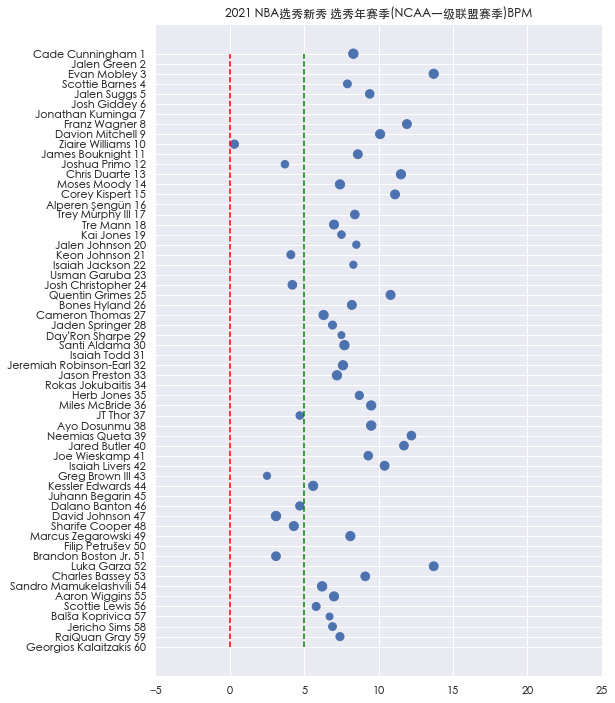

In [65]:
figsize(8, 12)
plot_draft_year(2021)

### 2020

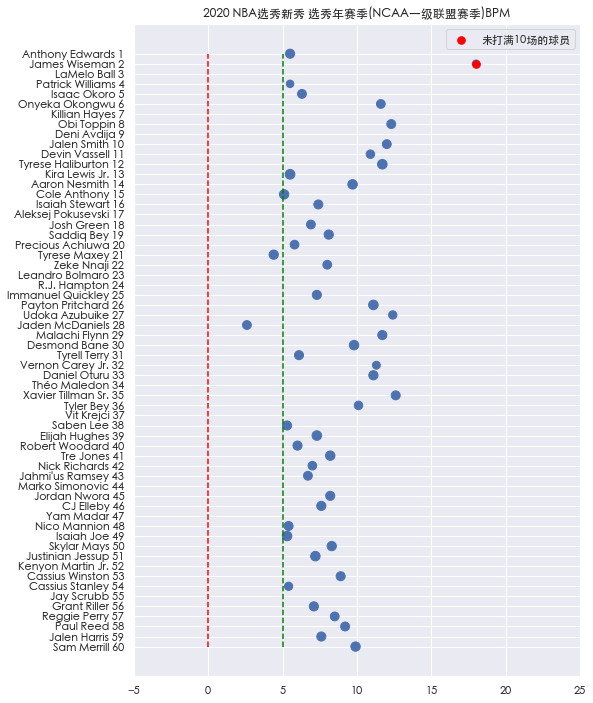

In [66]:
figsize(8, 12)
plot_draft_year(2020)

### 2019

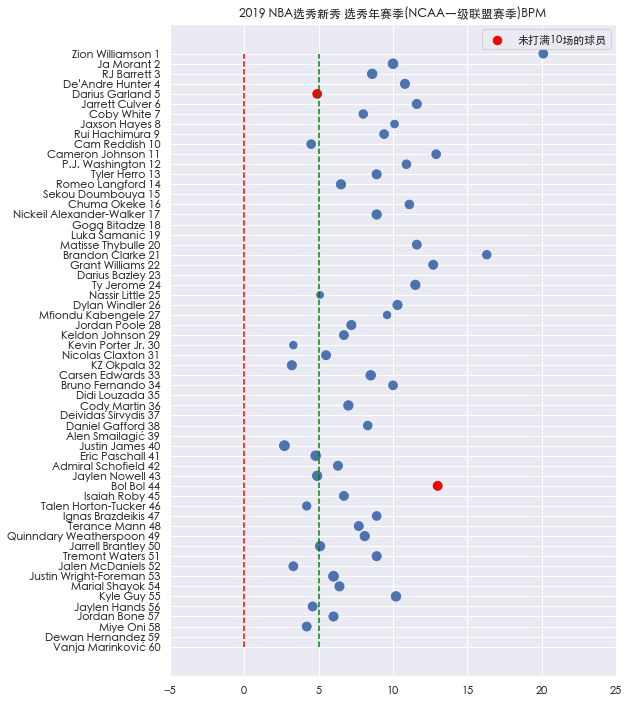

In [67]:
figsize(8, 12)
plot_draft_year(2019)

### 2018

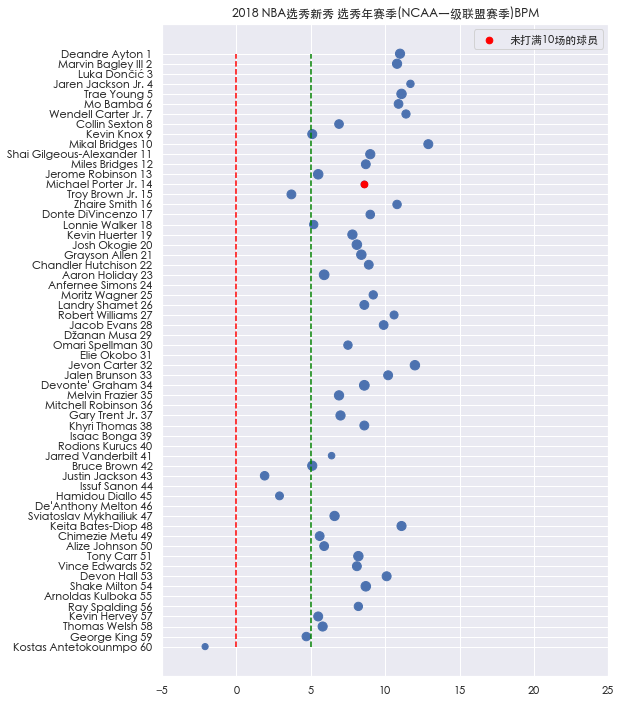

In [68]:
figsize(8, 12)
plot_draft_year(2018)

### 2017

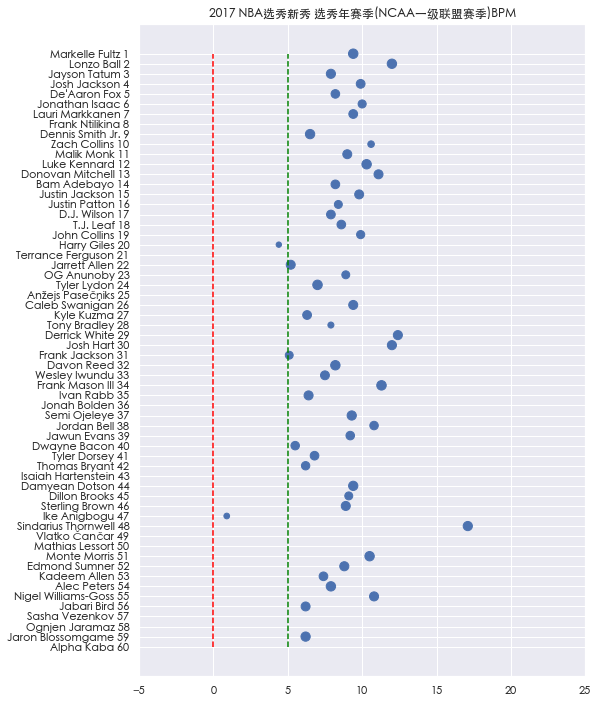

In [69]:
figsize(8, 12)
plot_draft_year(2017)

### 2016

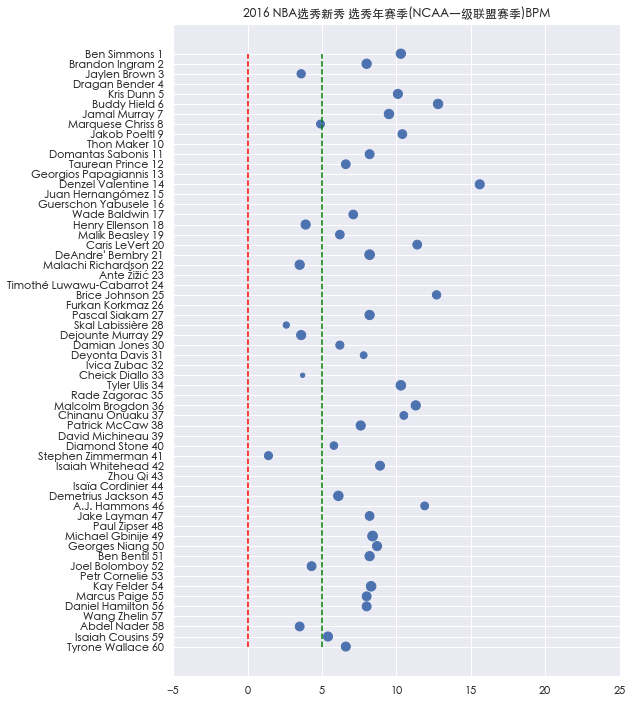

In [70]:
figsize(8, 12)
plot_draft_year(2016)

### 2015

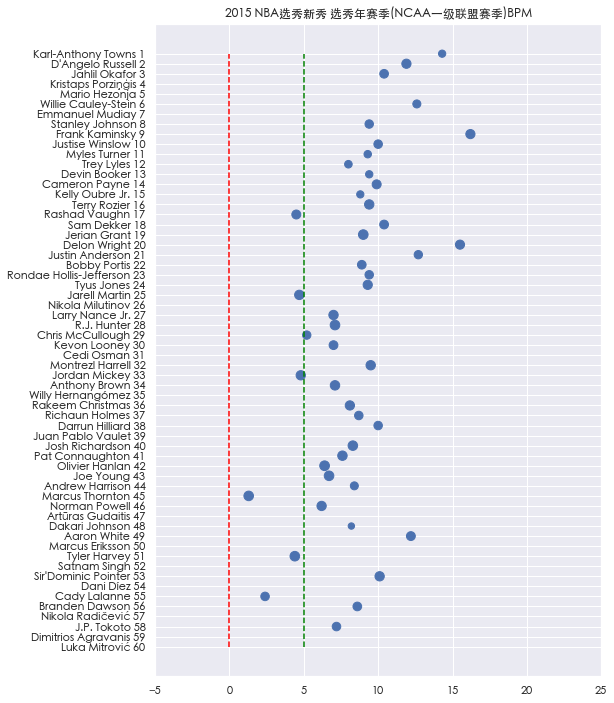

In [71]:
figsize(8, 12)
plot_draft_year(2015)

### 2014

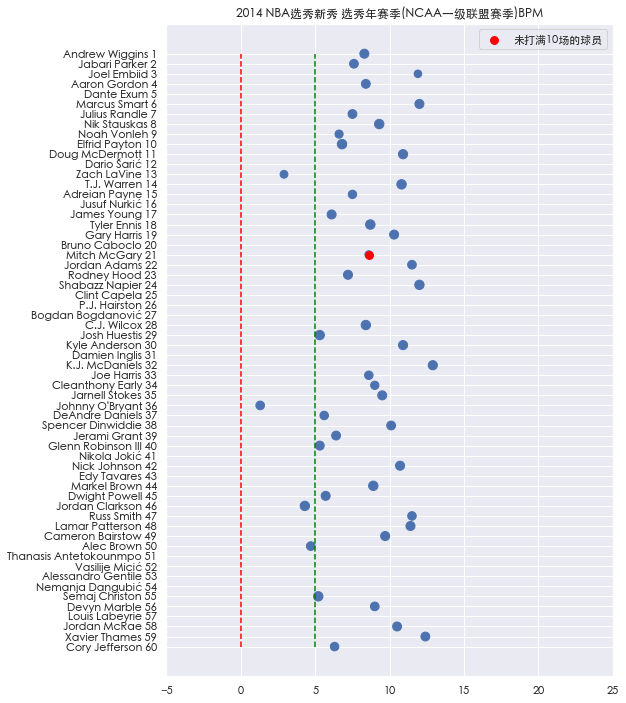

In [72]:
figsize(8, 12)
plot_draft_year(2014)

### 2013

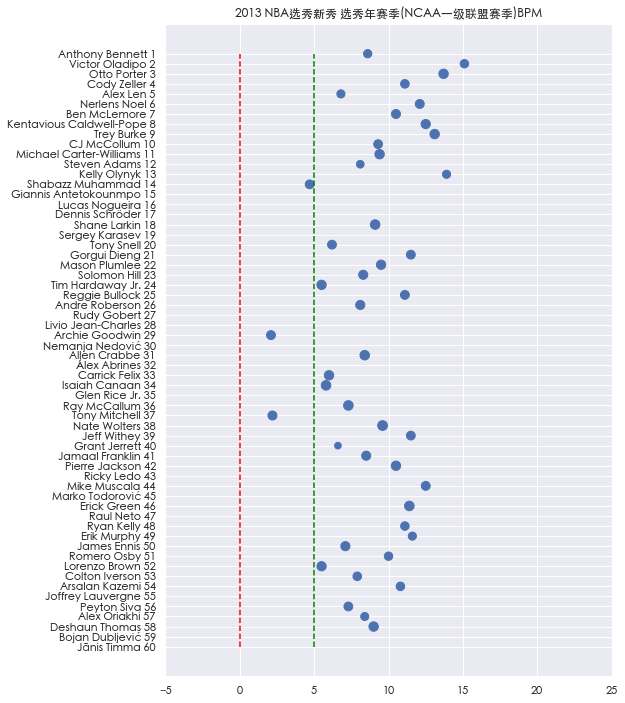

In [73]:
figsize(8, 12)
plot_draft_year(2013)

### 2012

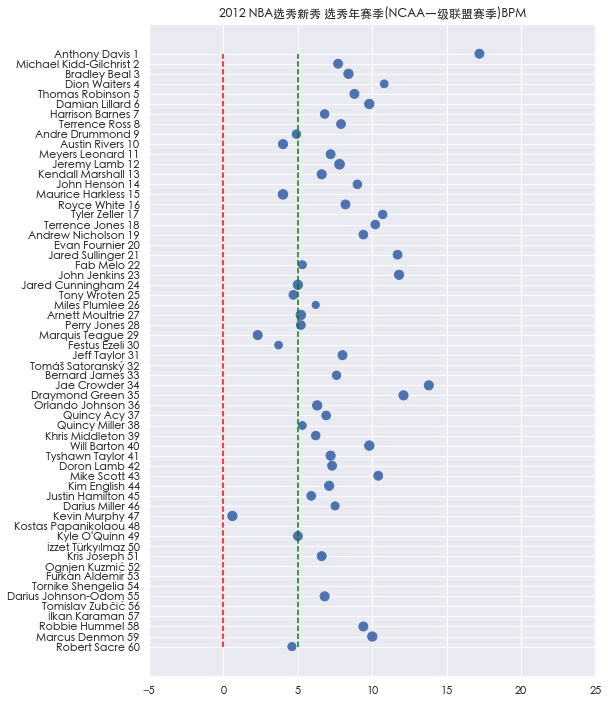

In [74]:
figsize(8, 12)
plot_draft_year(2012)

### 2011

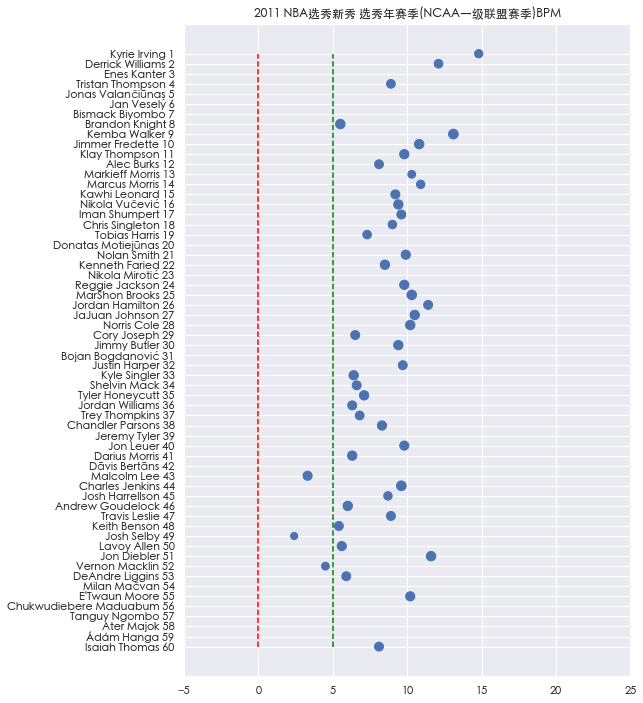

In [75]:
figsize(8, 12)
plot_draft_year(2011)